In [177]:
# Script for tracking busses. 
import urllib.request, json 
import datetime
import time as t
import pandas as pd

log_number = 5
loaded_data = []
data=None
t_runtime = 60*10
t_step = 10
t_elapsed = 0
running_dict = {}
while t_elapsed < t_runtime:
    t_elapsed+=t_step
    t.sleep(t_step)
    print(t_elapsed, end='\r')
    with urllib.request.urlopen("https://s3.amazonaws.com/kcm-alerts-realtime-prod/vehiclepositions_pb.json") as url:
        data = json.load(url)
        time = datetime.datetime.now()
        bus_id = pd.Series(pd.DataFrame(data['entity'])['id']).apply(lambda x: x.split("_")[1])
        route_id = pd.DataFrame(data['entity'])['vehicle'].apply(lambda x: x['trip']['route_id'])
        direction = pd.DataFrame(data['entity'])['vehicle'].apply(lambda x: x['trip']['direction_id'])
        position =  pd.DataFrame(data['entity'])['vehicle'].apply(lambda x: (x['position']['latitude'], x['position']['longitude']))
        data = pd.DataFrame([pd.Series(list(route_id)), pd.Series(list(bus_id)), pd.Series(list(direction))]).T
        data = data.rename(columns={0:'rid',1:'bid',2:'dir'})
        
        
        timepoint = pd.DataFrame([position]).T
        timepoint = timepoint.rename(columns={'vehicle':'geometry'})
        data['points'] = timepoint.apply(lambda x: (time, x.geometry), axis=1)
        
        for col, row in data.iterrows():
            x = row
            if "{}_{}_{}".format(x.rid,x.bid,x.dir) not in running_dict.keys():
                running_dict["{}_{}_{}".format(x.rid,x.bid,x.dir)] = []
                running_dict["{}_{}_{}".format(x.rid,x.bid,x.dir)].append(x.points)
            else:
                running_dict["{}_{}_{}".format(x.rid,x.bid,x.dir)].append(x.points)
        #data.apply(lambda x: running_dict["{}_{}_{}".format(x.rid,x.bid,x.dir)] = [x.points] if "{}_{}_{}".format(x.rid,x.bid,x.dir) not in running_dict.keys() else running_dict["{}_{}_{}".format(x.rid,x.bid,x.dir)].append(x.points), axis=1)

timelog = pd.DataFrame([running_dict.keys(), running_dict.values()]).T
timelog['rt'] = timelog[0].apply(lambda x: x.split("_")[0])
timelog['bus'] = timelog[0].apply(lambda x: x.split("_")[1])
timelog['dir'] = timelog[0].apply(lambda x: x.split("_")[2])
import KC_Query_Tools as kcqt
timelog['bus'] = timelog['bus'].apply(lambda x: kcqt.bus_type_finder(int(x)))
timelog.to_csv("timelog_{}.csv".format(log_number), index=False)

In [178]:

timelog = pd.DataFrame([running_dict.keys(), running_dict.values()]).T
timelog['rt'] = timelog[0].apply(lambda x: x.split("_")[0])
timelog['bus'] = timelog[0].apply(lambda x: x.split("_")[1])
timelog['dir'] = timelog[0].apply(lambda x: x.split("_")[2])
import KC_Query_Tools as kcqt
#timelog['bus'] = timelog['bus'].apply(lambda x: kcqt.bus_type_finder(int(x)))
timelog.to_csv("timelog_{}.csv".format(log_number), index=False)

In [196]:
timelog['bus'].value_counts()

bus
XDE60      166
BRT        103
OBI6        86
DE60LFR     67
NA          50
XT40        47
XDE35       33
XDE40       26
XT60        24
DE60LFA     10
XE40         1
Name: count, dtype: int64

[100006 100016 100017 100042 100202 100230 102702 102747]


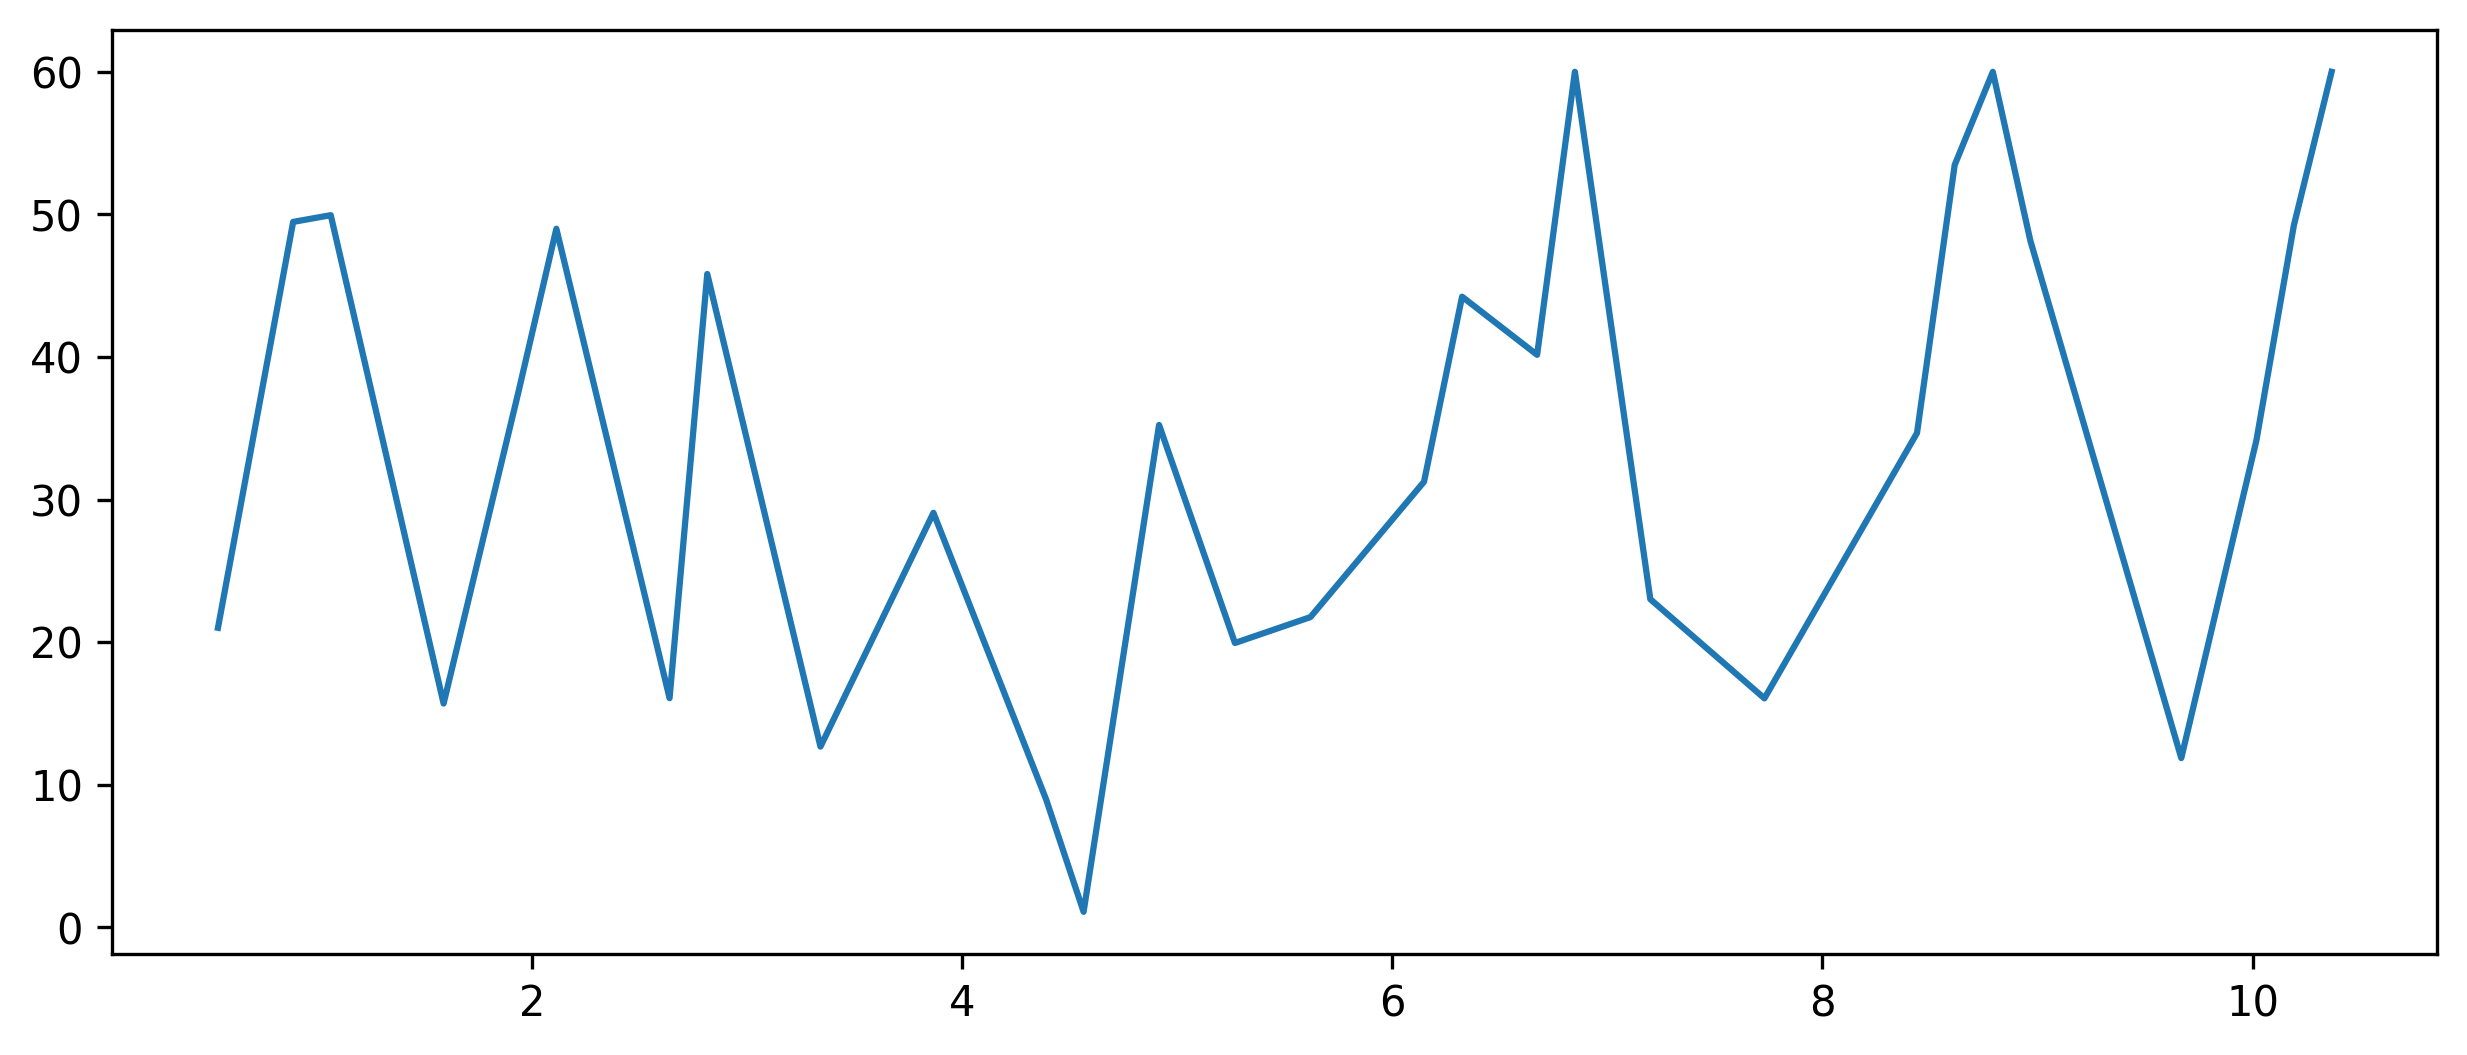

In [193]:
import sys
sys.path.append('../src/reRoute_Dynamics_Core/')
import shapely
import Geography_Tools as gt
import pandas as pd
import matplotlib.pyplot as plt
import KC_Query_Tools as kcqt
import datetime
import geopandas as gpd

timelog = pd.read_csv("timelog_5.csv")
timelog['bus'] = timelog['bus'].apply(lambda x: kcqt.bus_type_finder(int(x)) if x != "block" else "NA")
bus_filter = timelog[timelog['bus'].isin(['XDE35'])]
print(bus_filter['rt'].unique())
id_filter = bus_filter[bus_filter['rt'] == 100016].reset_index(drop=True)
rundata = str(id_filter['1'][0])
datapoint_strings = pd.Series(rundata[1:-1].replace(")), ", "))|").replace("), (", ")^(").split("|"))
datetimes = datapoint_strings.apply(lambda x: datetime.datetime(*eval(x.split("^")[0][18:])))

geometry = datapoint_strings.apply(lambda x: shapely.Point(x.split("^")[1][1:-2].split(", ")))
dt = datetimes.diff().apply(lambda x: x.total_seconds() if x == x else 0)
geotimes = pd.DataFrame([geometry, dt]).T

geotimes.columns=["geometry", "dt"]
geotimes['pt'] = geotimes['geometry'].apply(lambda x: "{},{}".format(x.x, x.y))

geometry = pd.Series(geotimes.groupby("pt")['dt'].sum().keys())
dt = pd.Series(geotimes.groupby("pt")['dt'].sum().values)
geotimes = pd.DataFrame([geometry, dt]).T
geotimes.columns=["geometry", "dt"]
geotimes['geometry'] = geotimes['geometry'].apply(lambda x: shapely.Point(x.split(",")))
geotimes = gpd.GeoDataFrame(geotimes).set_crs(epsg=4326)
geotimes['dx'] = gt.query_distance_traveled(geotimes['geometry'])*1000
geotimes['geometry'] = geotimes['geometry'].apply(lambda x: shapely.ops.transform(gt._flip, x))
geotimes['dt'] = geotimes['dt'].shift(-1)
geotimes = geotimes[:-1]
geotimes['v'] = (geotimes['dx']/geotimes['dt']).apply(float) * 2.2369
geotimes['v'] = geotimes['v'].apply(lambda x: 60*(x>60) + x*(x<60))
geotimes['t'] = (geotimes['dt'].cumsum()/60).apply(float)
fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=300)
ax.plot(geotimes['t'], geotimes['v'])

(47.27, 47.78)

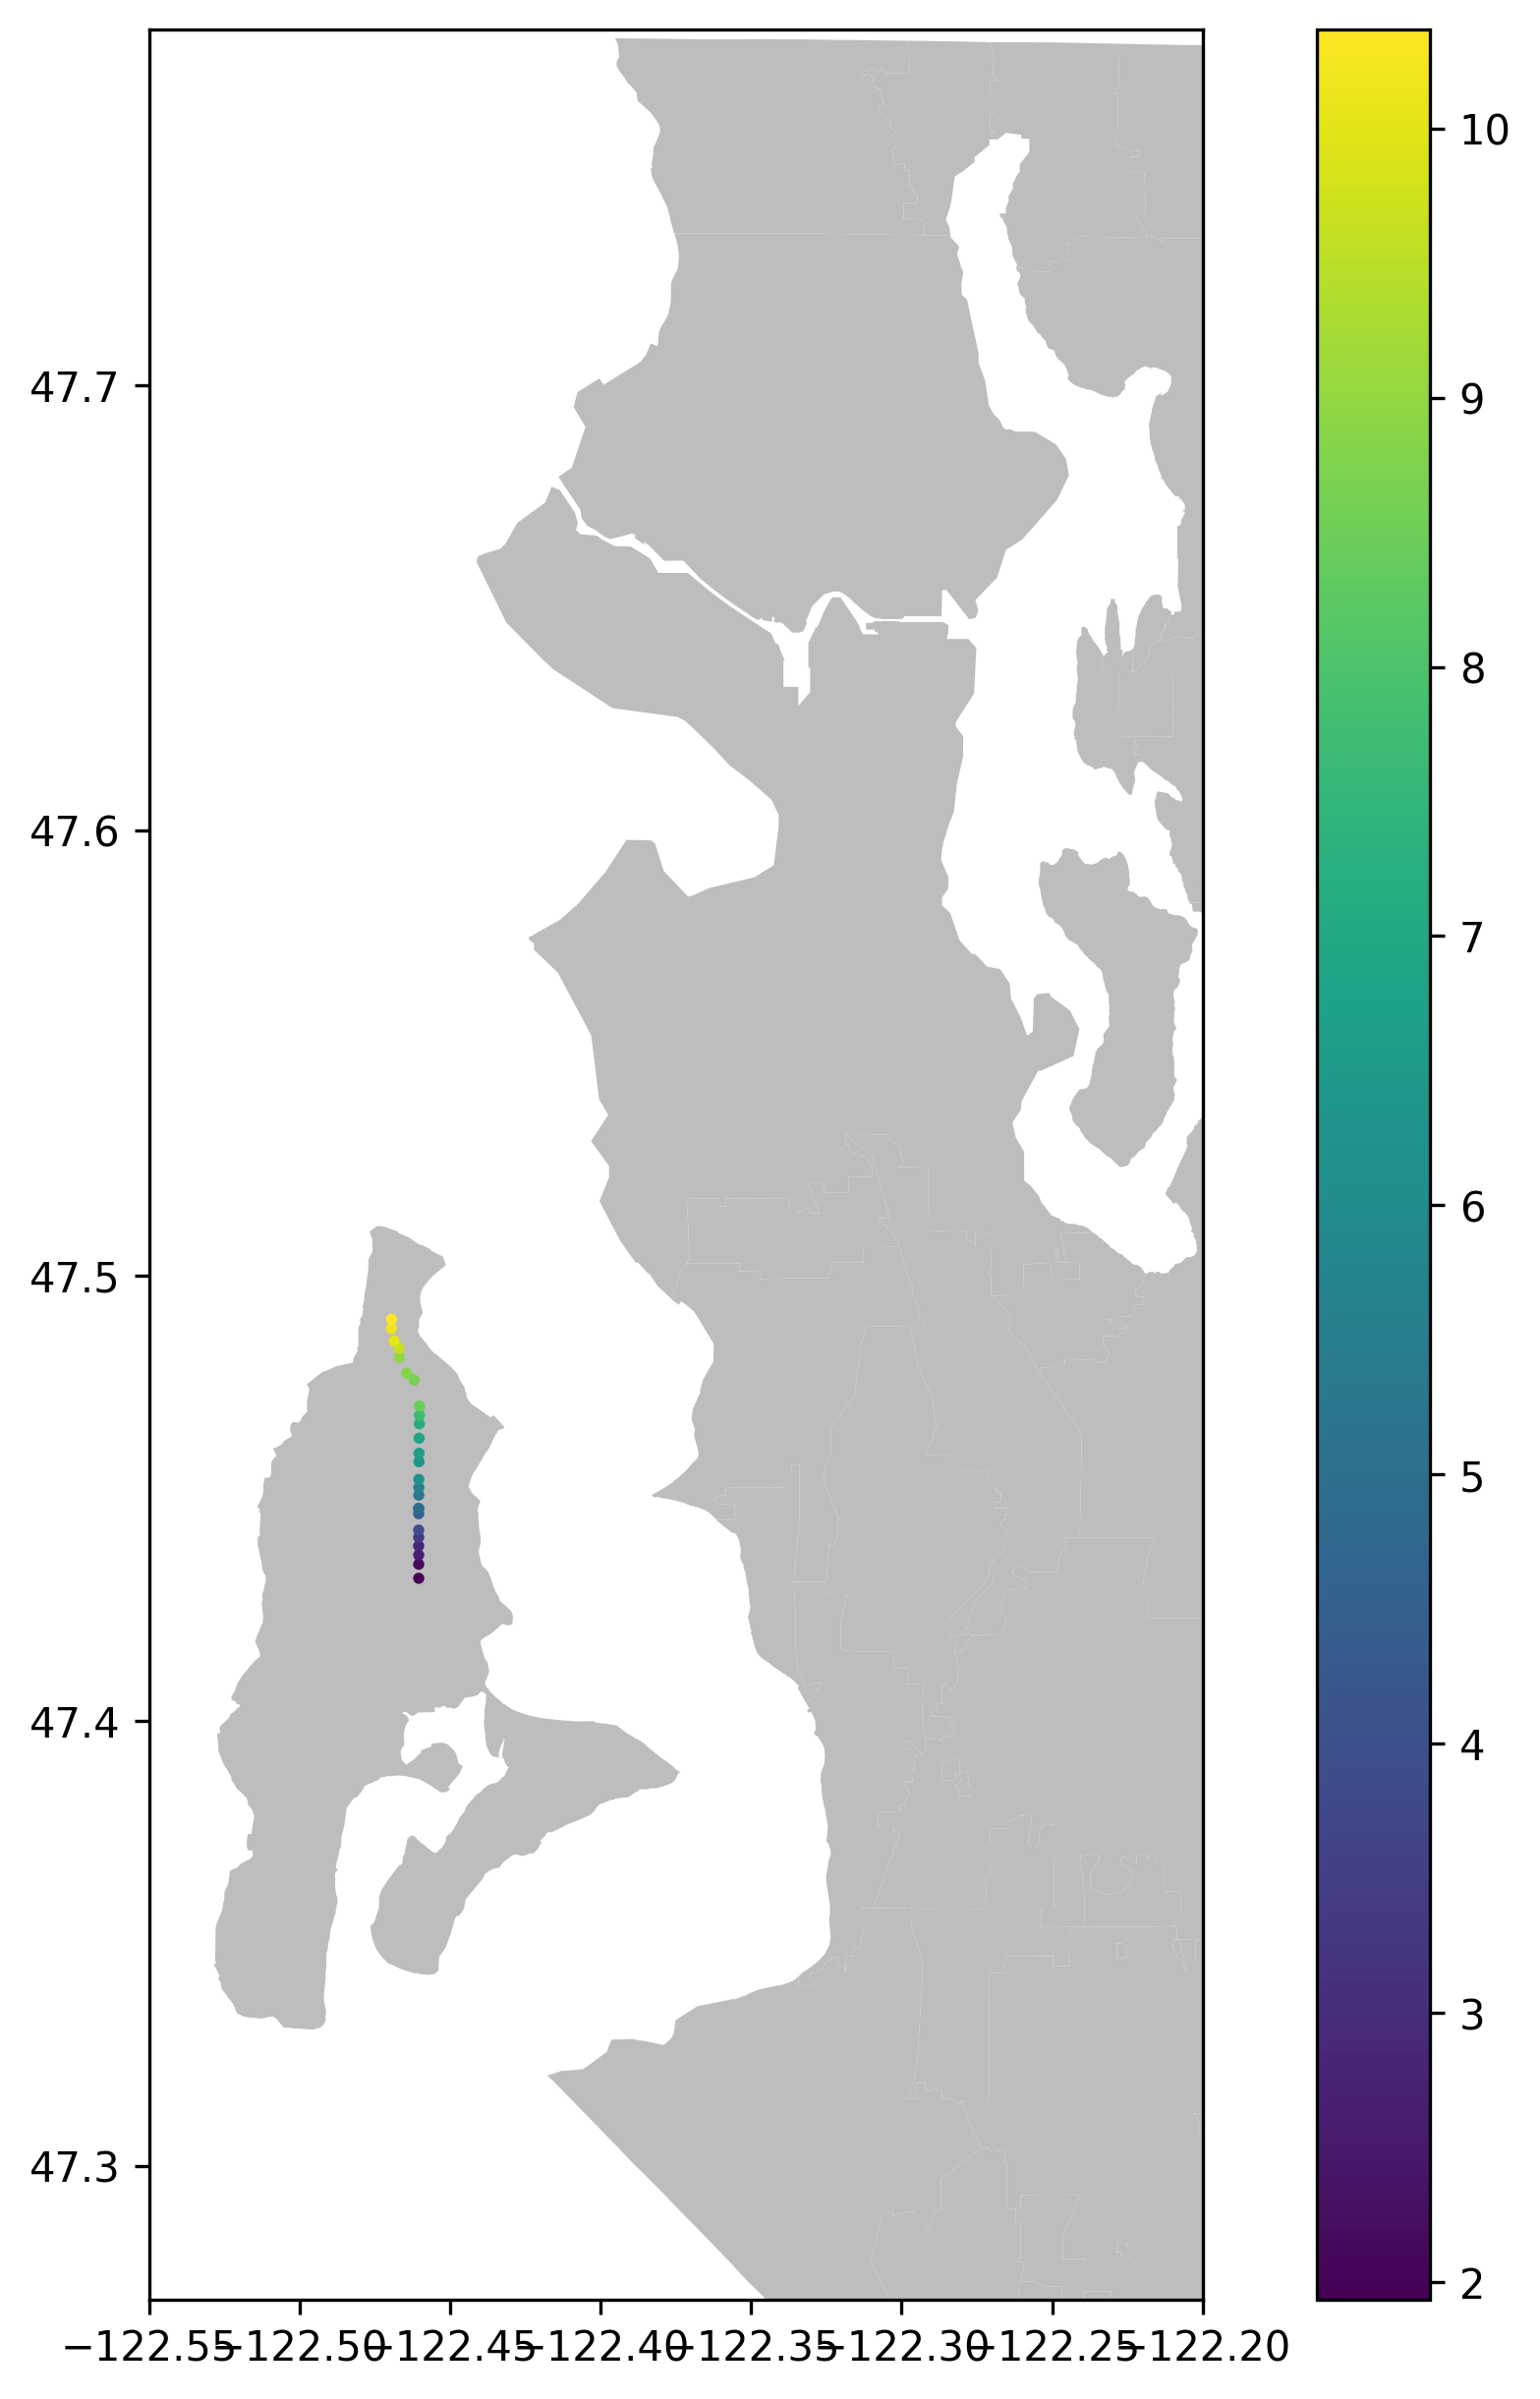

In [194]:
map_path = '/media/sebastian/Slepnir/KC_Map/map/Incorporated_Areas_of_King_County___citydst_area.shp'
def blank_kc_canvas():
    '''
    Plotting method to setup a blank canvas in EPSG:4326 with a map of king county.
    '''
    fig, ax = plt.subplots(1,1,figsize=(10, 10), dpi = 300)
    king_county_map = gpd.read_file(map_path).to_crs(epsg=4326)
    king_county_map.plot(ax=ax, zorder=1, color='#BDBDBD')
    ax.set_xlim(-122.6, -121.0)
    ax.set_ylim(47.05, 47.81)
    return fig, ax
fig, ax = blank_kc_canvas()
geotimes[4:].plot(column = 't',markersize = 3, legend=True, ax=ax)
ax.set_xlim(-122.55, -122.2)
ax.set_ylim(47.27, 47.78)

/tmp/ipykernel_6577/1168368283.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rundata = str(id_filter.iloc[0][1])


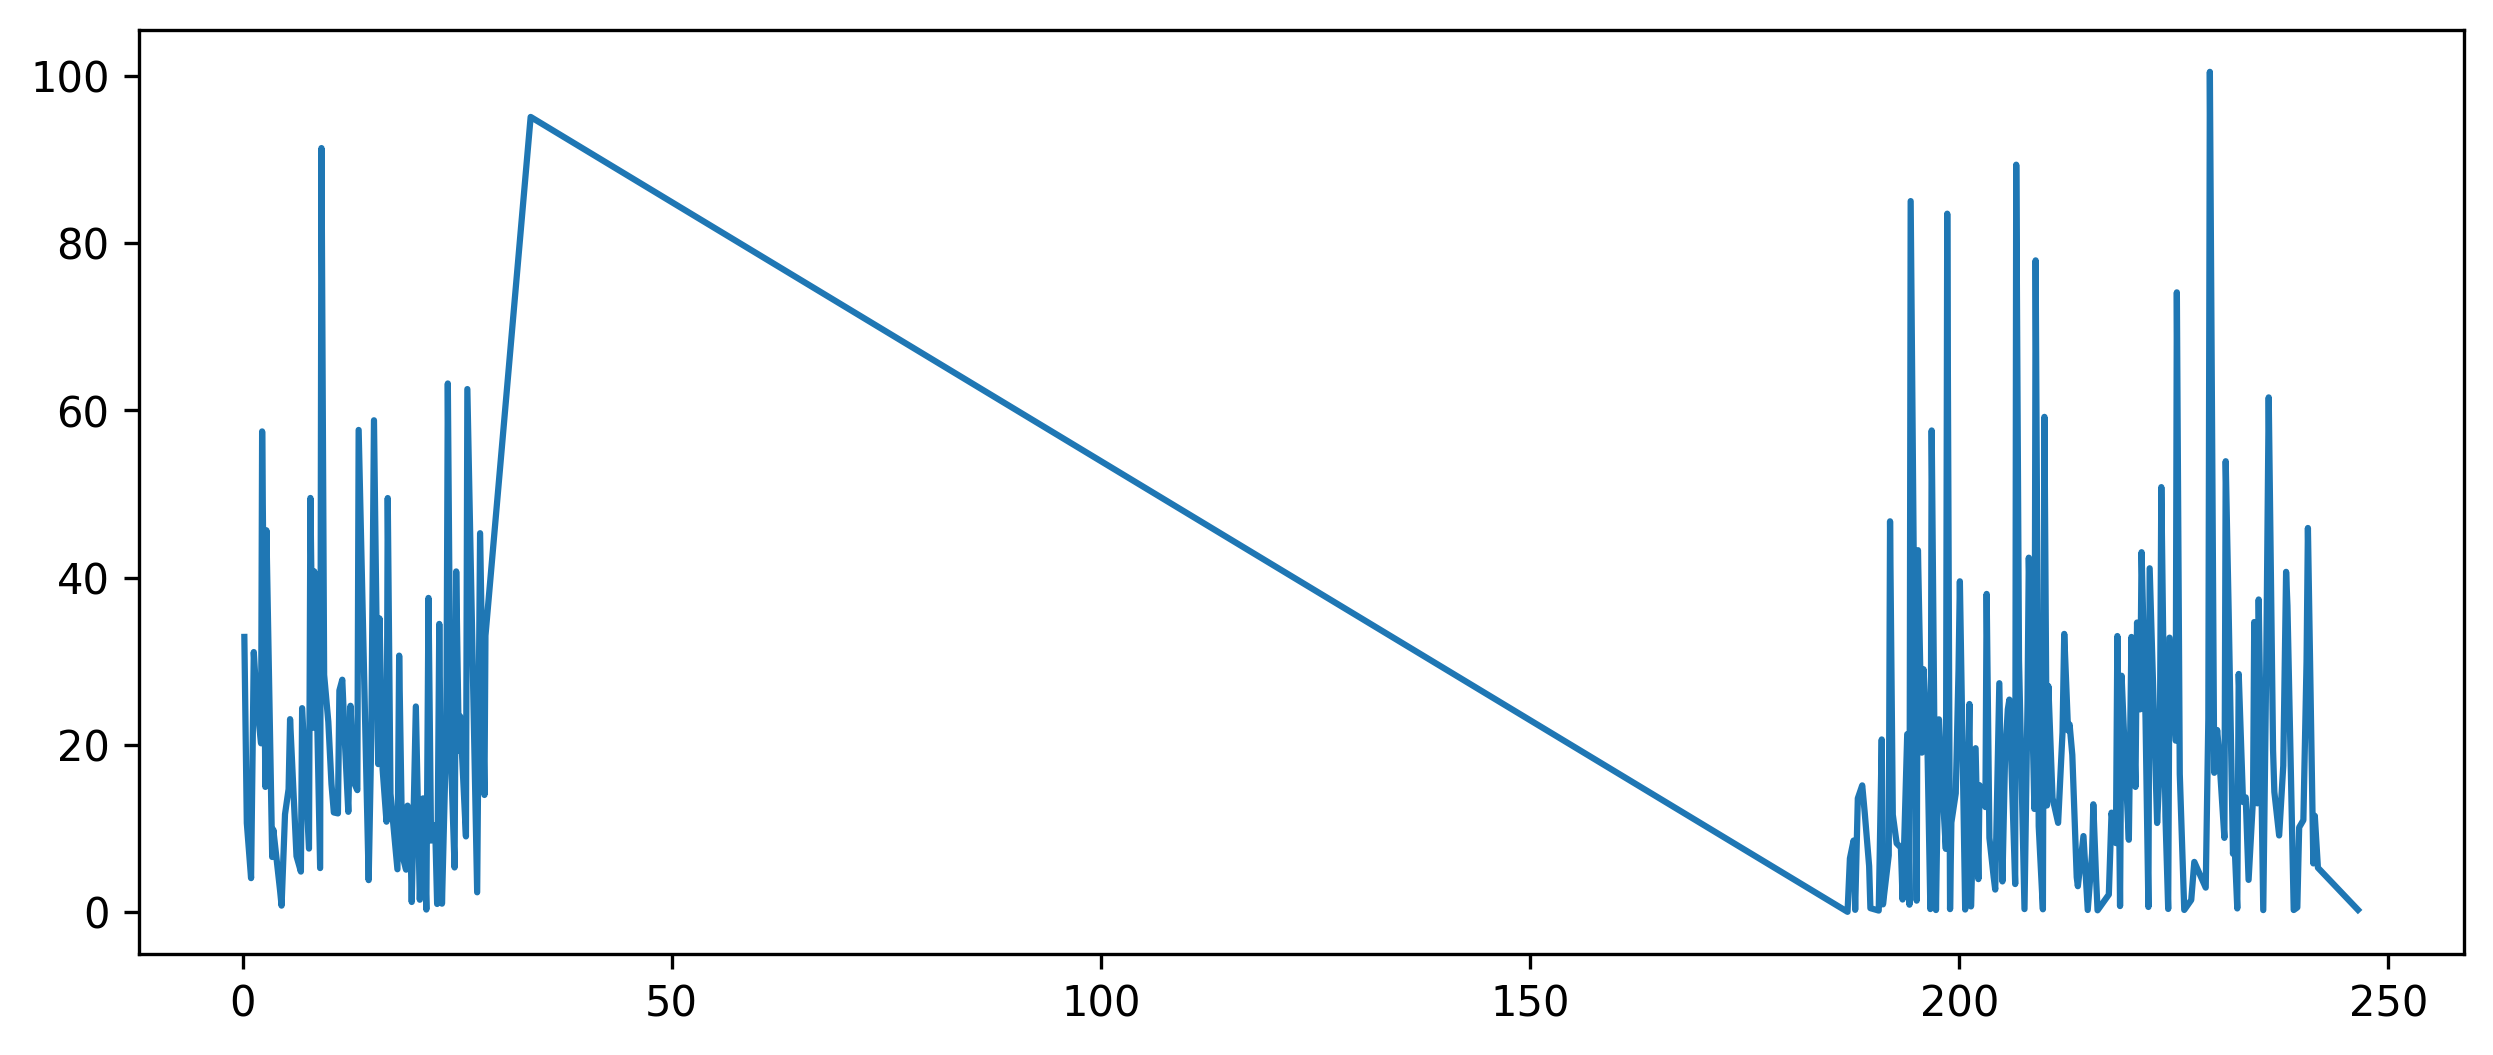

In [26]:
bus_filter = timelog[timelog['bus'].isin(['XDE35'])]
id_filter = bus_filter[bus_filter['rt'] == 100006]
rundata = str(id_filter.iloc[0][1])
unsorted = rundata[1:-2].split(", ")
batch_size = 9
form = '%H, %M, %S, %f'
rows = [unsorted[i:i + batch_size] for i in range(0, len(unsorted), batch_size)]
times = pd.Series(rows).apply(lambda x: datetime.datetime.strptime(", ".join(x[0:7])[32:-1], form))
geometry = pd.Series(rows).apply(lambda x: shapely.Point(", ".join(x[7:9])[1:-2].split(", ")))
dx = gt.query_distance_traveled(geometry)
dt = times.diff()
dt = dt[1:]
dt = dt.apply(lambda x: x.to_pytimedelta().total_seconds())

timedata = pd.DataFrame([dx[1:], dt, dx[1:]]).T
data = []
entry = {0:0,1:0,2:0}
for i in range(len(timedata)):
    row = timedata.iloc[i]
    if row[0] == 0:
        entry[1]+=row[1]
        entry[2]+=row[2]
    else:
        entry[1]+=row[1]
        entry[2]+=row[2]
        entry[0]+=row[0]
        
        data.append(entry)
        entry = {0:0,1:0,2:0}
data = pd.DataFrame(data)
data[2] = data[0]*1000*2.236936/data[1]
dist = dx.cumsum()
fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=300)
ax.plot(data[1].cumsum()/60, data[2])

24     100006
26     100006
33     100016
70     100042
72     100042
173    100202
174    100202
234    100230
235    100230
236    100230
237    100230
238    100230
239    100230
240    100230
241    100230
242    100230
432    102702
433    102702
434    102702
491    102747
492    102747
493    102747
494    102747
495    102747
496    100016
503    100202
517    100202
522    100006
534    100230
551    102702
564    100006
585    100042
607    102747
639    100230
713    102702
730    100230
771    102747
772    100230
798    102747
811    100006
827    102747
829    100016
834    100006
847    100202
871    100202
875    100042
925    100006
928    100230
931    102702
939    102747
944    100230
976    100042
Name: rt, dtype: object

In [5]:
import pandas as pd
data = pd.read_csv('bus_time_tracking2.csv')

In [ ]:
rundata = data[data['btype'].isin(['XDE35'])].reset_index(drop=True).iloc[0][3]
dat = pd.Series(rundata[2:-2].split("), ("))#.apply(lambda x: x.split(", "))
dat[0]

/tmp/ipykernel_95349/3710611616.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rundata = data[data['btype'].isin(['XDE35'])].reset_index(drop=True).iloc[0][3]


'datetime.datetime(2025, 1, 27, 14, 30, 10, 253487), <POINT (47.533 -122.289)>'

In [16]:
routes = pd.DataFrame(pd.Series(saved_routes))
# Make the column 'path'
routes.columns = ['path']


In [17]:
routes

,path
0,./..//..//..//..//..//..//media/sebastian/Slep...
1,./..//..//..//..//..//..//media/sebastian/Slep...
2,./..//..//..//..//..//..//media/sebastian/Slep...
3,./..//..//..//..//..//..//media/sebastian/Slep...
4,./..//..//..//..//..//..//media/sebastian/Slep...
...,...
521,./..//..//..//..//..//..//media/sebastian/Slep...
522,./..//..//..//..//..//..//media/sebastian/Slep...
523,./..//..//..//..//..//..//media/sebastian/Slep...
524,./..//..//..//..//..//..//media/sebastian/Slep...
